In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
!pip install dive-into-graphs
!pip install pydig

1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from termcolor import colored
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np

from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf

#. DGL
import dgl
import dgl.function as fn
from dgl.data import GINDataset
from dgl.nn import GNNExplainer as GNNExplainer_DGL
from dgl.dataloading import GraphDataLoader
from dgl.nn import AvgPooling
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset


#. DIG
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.method import PGExplainer
from dig.xgraph.utils.compatibility import compatible_state_dict
from dig.xgraph.method.subgraphx import PlotUtils
from dig.xgraph.method.subgraphx import MCTS
from torch_geometric.utils import to_networkx
from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
from dig.xgraph.models import GCN_2l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
Explainability_name = 'PGExplainer'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
#dataset = SynGraphDataset('./datasets', 'BA_shapes')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Number of test nodes: 1000
Number of val nodes: 500
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))
print("-------------------------------------")


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556
-------------------------------------


In [ ]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

In [ ]:
def split_dataset(dataset):
    indices = []
    train_percent = 0.7

    num_classes = dataset.num_classes
    
    for i in range(num_classes):
        index = (dataset.data.y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)

    train_index = torch.cat([i[:int(len(i) * train_percent)] for i in indices], dim=0)
    rest_index = torch.cat([i[int(len(i) * train_percent):] for i in indices], dim=0)

    #print(len(train_index.tolist()), len(rest_index.tolist()))

    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
    dataset.data.test_mask = index_to_mask(rest_index, size=dataset.data.num_nodes)

    dataset.data, dataset.slices = dataset.collate([dataset.data])

    return dataset
    #return train_index, rest_index

In [ ]:
dataset2 = split_dataset(dataset)
dataset_PGExplainer = dataset2[0]
print(dataset_PGExplainer)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# **GCN MODEL**

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
      super().__init__()
      torch.manual_seed(1234567)
      self.conv1 = GCNConv(dataset.num_features, hidden_channels)
      self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
      self.linear1 = Linear(7,7)

  def forward(self, x, edge_index):
      x = self.conv1(x, edge_index)
      x = F.relu(x)

      x = self.conv2(x, edge_index)
      x = F.relu(x)

      x = self.linear1(x)
      x = F.relu(x)

      x = F.dropout(x, p=0.5, training=self.training)
      return x

GCN_Model_mine = GCN(hidden_channels=7)
print(GCN_Model_mine)

GCN(
  (conv1): GCNConv(1433, 7)
  (conv2): GCNConv(7, 7)
  (linear1): Linear(in_features=7, out_features=7, bias=True)
)


GCN_2l(
  (conv1): GCNConv(1433, 100)
  (convs): ModuleList(
    (0): GCNConv(100, 100)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): IdenticalPool()
  (ffn): Sequential(
    (0): Linear(in_features=100, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


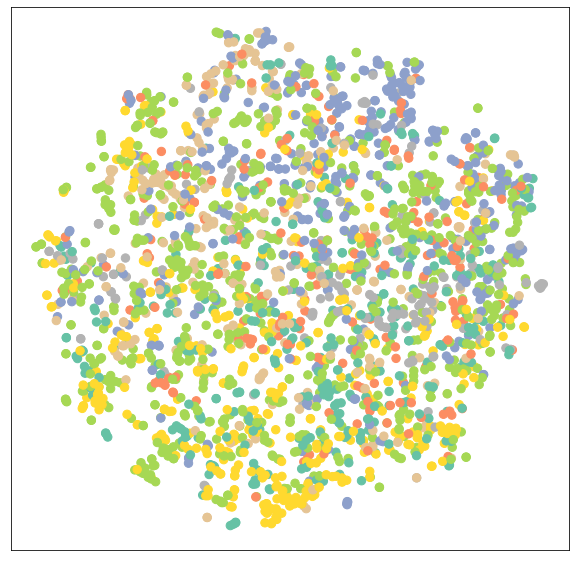

In [ ]:
GCN_Model = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
print(GCN_Model)
#GCN_Model = GCN(16)
GCN_Model.eval()

out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(out, color=data.y)


In [ ]:
GCN_Model_Optimizer = torch.optim.Adam(GCN_Model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [ ]:
def loading_model(load_index):
  GCN_Model = GCN_2l(model_level='node', dim_node=1433, dim_hidden=100, num_classes=7)
  GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.01)
  checkpoint = torch.load("/content/drive/My Drive/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GCN_Model.load_state_dict(checkpoint['model_state_dict'])
  GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GCN_Model, GCN_Model_Optimizer, epoch

In [ ]:
def visualize_losses(gcn_losses, epoch_history):
  gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
  ax.plot(gcn_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [ ]:
def train_step():
  GCN_Model.train(True)

  GCN_Model_Optimizer.zero_grad()  
  GCN_Model_out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)  

  GCN_Model_loss = loss_calculations(GCN_Model_out[dataset_PGExplainer.train_mask], dataset_PGExplainer.y[dataset_PGExplainer.train_mask])  
  GCN_Model_loss.backward(retain_graph=True)

  GCN_Model_Optimizer.step()    


  return GCN_Model_loss


In [ ]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  GCN_Model_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GCN_Model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GCN_Model_training_loss:.4f}')

    GCN_Model_training_loss_per_epoch.append(GCN_Model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GCN_Model_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GCN_Model.state_dict(), 'optimizer_state_dict': GCN_Model_Optimizer.state_dict(), 'loss': GCN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




Epoch: 001, PGExplainer Model Loss: 1.9570
Epoch: 002, PGExplainer Model Loss: 1.9409
Epoch: 003, PGExplainer Model Loss: 1.9155
Epoch: 004, PGExplainer Model Loss: 1.8803
Epoch: 005, PGExplainer Model Loss: 1.8412
Epoch: 006, PGExplainer Model Loss: 1.8161
Epoch: 007, PGExplainer Model Loss: 1.8220
Epoch: 008, PGExplainer Model Loss: 1.8117
Epoch: 009, PGExplainer Model Loss: 1.7882
Epoch: 010, PGExplainer Model Loss: 1.7700
Epoch: 011, PGExplainer Model Loss: 1.7578
Epoch: 012, PGExplainer Model Loss: 1.7450
Epoch: 013, PGExplainer Model Loss: 1.7267
Epoch: 014, PGExplainer Model Loss: 1.7006
Epoch: 015, PGExplainer Model Loss: 1.6674
Epoch: 016, PGExplainer Model Loss: 1.6310
Epoch: 017, PGExplainer Model Loss: 1.5941
Epoch: 018, PGExplainer Model Loss: 1.5541
Epoch: 019, PGExplainer Model Loss: 1.5078
Epoch: 020, PGExplainer Model Loss: 1.4610
Epoch: 021, PGExplainer Model Loss: 1.4158
Epoch: 022, PGExplainer Model Loss: 1.3658
Epoch: 023, PGExplainer Model Loss: 1.3162
Epoch: 024,

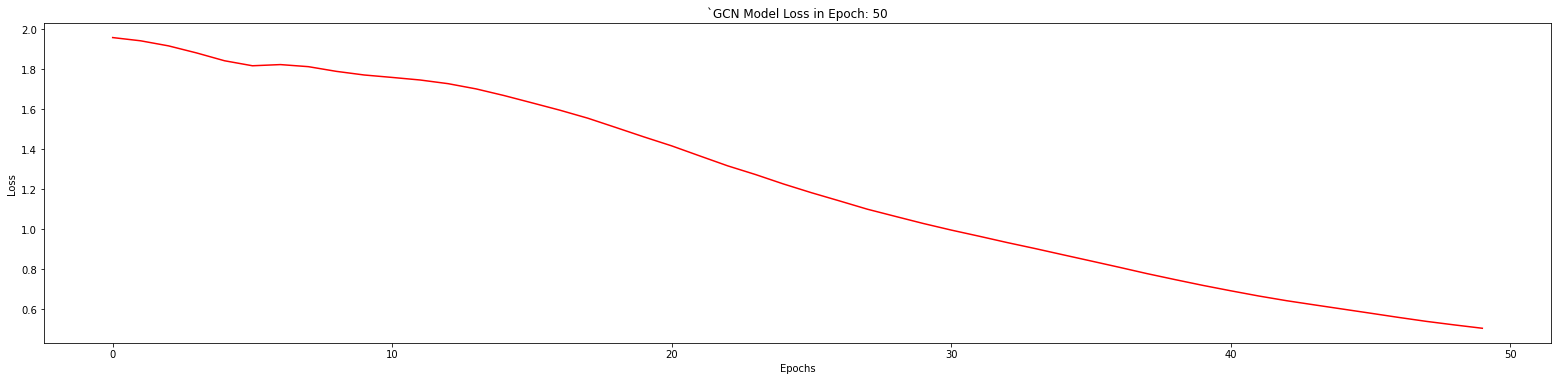

Epoch: 051, PGExplainer Model Loss: 0.4886
Epoch: 052, PGExplainer Model Loss: 0.4752
Epoch: 053, PGExplainer Model Loss: 0.4642
Epoch: 054, PGExplainer Model Loss: 0.4469
Epoch: 055, PGExplainer Model Loss: 0.4280
Epoch: 056, PGExplainer Model Loss: 0.4159
Epoch: 057, PGExplainer Model Loss: 0.4050
Epoch: 058, PGExplainer Model Loss: 0.3906
Epoch: 059, PGExplainer Model Loss: 0.3765
Epoch: 060, PGExplainer Model Loss: 0.3647
Epoch: 061, PGExplainer Model Loss: 0.3528
Epoch: 062, PGExplainer Model Loss: 0.3413
Epoch: 063, PGExplainer Model Loss: 0.3310
Epoch: 064, PGExplainer Model Loss: 0.3193
Epoch: 065, PGExplainer Model Loss: 0.3077
Epoch: 066, PGExplainer Model Loss: 0.2995
Epoch: 067, PGExplainer Model Loss: 0.2915
Epoch: 068, PGExplainer Model Loss: 0.2803
Epoch: 069, PGExplainer Model Loss: 0.2705
Epoch: 070, PGExplainer Model Loss: 0.2636
Epoch: 071, PGExplainer Model Loss: 0.2563
Epoch: 072, PGExplainer Model Loss: 0.2482
Epoch: 073, PGExplainer Model Loss: 0.2411
Epoch: 074,

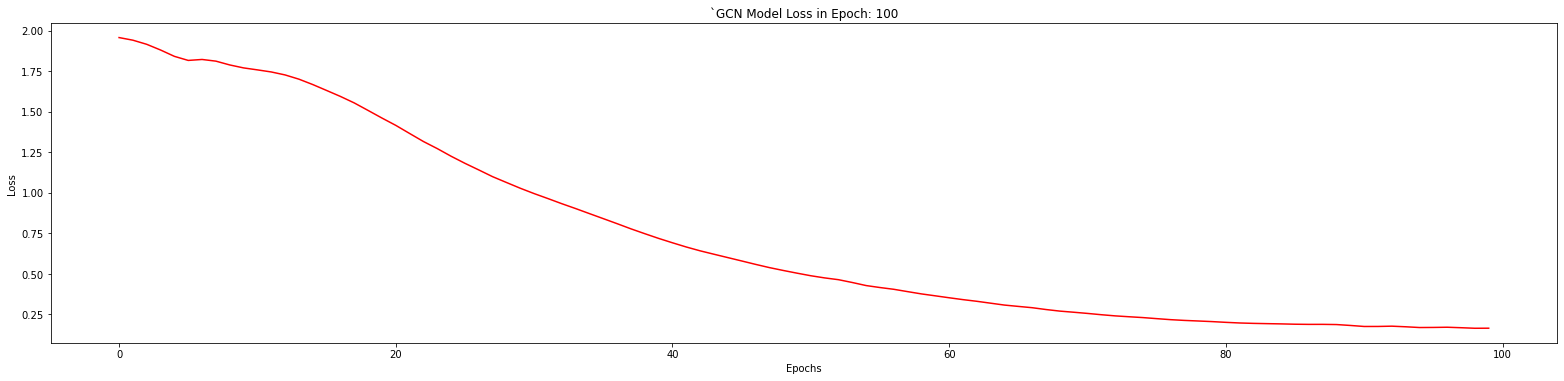

Epoch: 101, PGExplainer Model Loss: 0.1660
Epoch: 102, PGExplainer Model Loss: 0.1639
Epoch: 103, PGExplainer Model Loss: 0.1613
Epoch: 104, PGExplainer Model Loss: 0.1612
Epoch: 105, PGExplainer Model Loss: 0.1617
Epoch: 106, PGExplainer Model Loss: 0.1604
Epoch: 107, PGExplainer Model Loss: 0.1582
Epoch: 108, PGExplainer Model Loss: 0.1574
Epoch: 109, PGExplainer Model Loss: 0.1578
Epoch: 110, PGExplainer Model Loss: 0.1574
Epoch: 111, PGExplainer Model Loss: 0.1560
Epoch: 112, PGExplainer Model Loss: 0.1546
Epoch: 113, PGExplainer Model Loss: 0.1541
Epoch: 114, PGExplainer Model Loss: 0.1542
Epoch: 115, PGExplainer Model Loss: 0.1539
Epoch: 116, PGExplainer Model Loss: 0.1530
Epoch: 117, PGExplainer Model Loss: 0.1523
Epoch: 118, PGExplainer Model Loss: 0.1528
Epoch: 119, PGExplainer Model Loss: 0.1565
Epoch: 120, PGExplainer Model Loss: 0.1637
Epoch: 121, PGExplainer Model Loss: 0.1645
Epoch: 122, PGExplainer Model Loss: 0.1571
Epoch: 123, PGExplainer Model Loss: 0.1570
Epoch: 124,

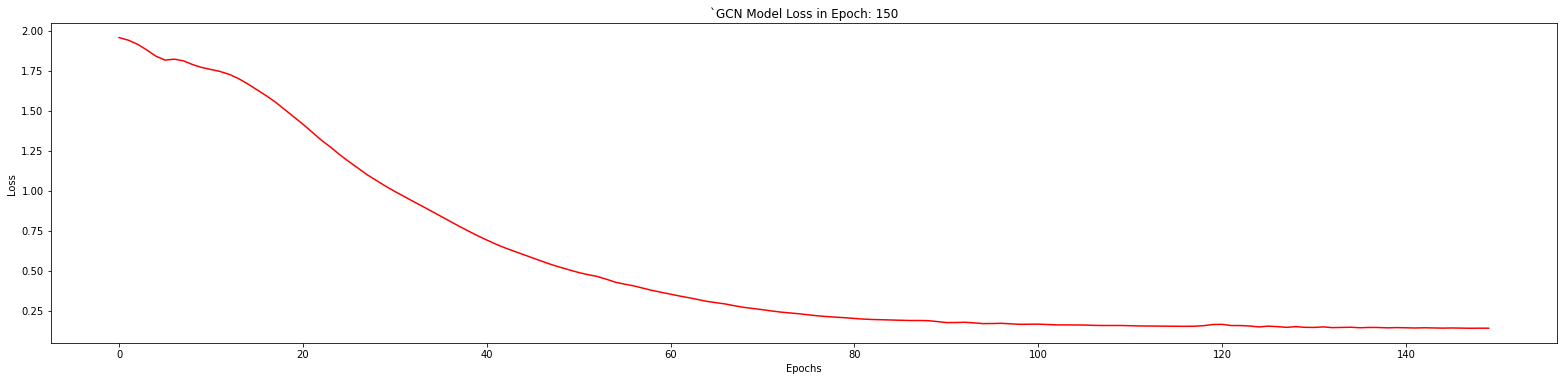

Epoch: 151, PGExplainer Model Loss: 0.1394
Epoch: 152, PGExplainer Model Loss: 0.1397
Epoch: 153, PGExplainer Model Loss: 0.1399
Epoch: 154, PGExplainer Model Loss: 0.1394
Epoch: 155, PGExplainer Model Loss: 0.1400
Epoch: 156, PGExplainer Model Loss: 0.1416
Epoch: 157, PGExplainer Model Loss: 0.1438
Epoch: 158, PGExplainer Model Loss: 0.1468
Epoch: 159, PGExplainer Model Loss: 0.1506
Epoch: 160, PGExplainer Model Loss: 0.1482
Epoch: 161, PGExplainer Model Loss: 0.1401
Epoch: 162, PGExplainer Model Loss: 0.1358
Epoch: 163, PGExplainer Model Loss: 0.1392
Epoch: 164, PGExplainer Model Loss: 0.1416
Epoch: 165, PGExplainer Model Loss: 0.1385
Epoch: 166, PGExplainer Model Loss: 0.1352
Epoch: 167, PGExplainer Model Loss: 0.1355
Epoch: 168, PGExplainer Model Loss: 0.1379
Epoch: 169, PGExplainer Model Loss: 0.1383
Epoch: 170, PGExplainer Model Loss: 0.1353
Epoch: 171, PGExplainer Model Loss: 0.1339
Epoch: 172, PGExplainer Model Loss: 0.1356
Epoch: 173, PGExplainer Model Loss: 0.1365
Epoch: 174,

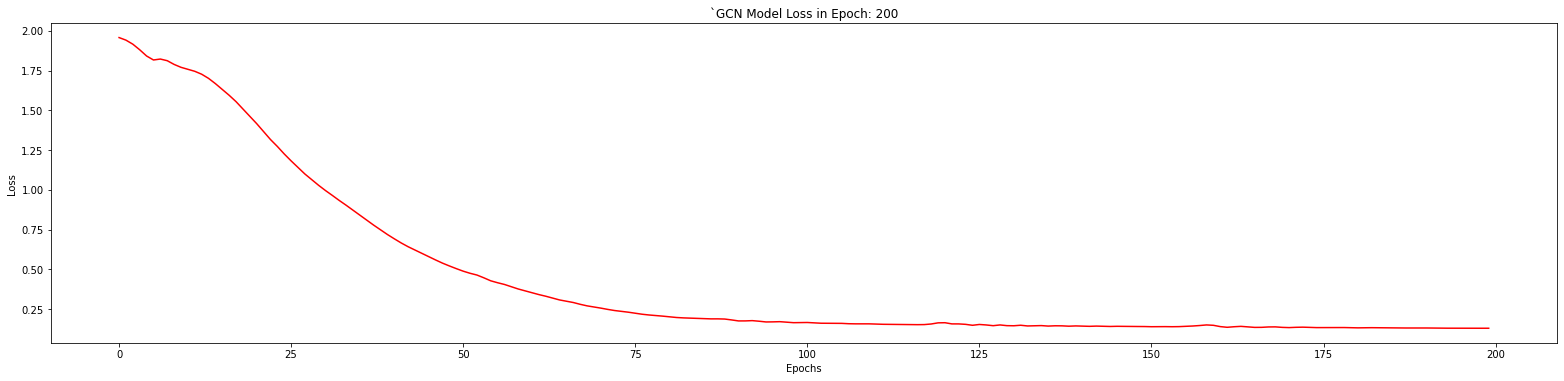

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:
def GCN_Model_test():
  GCN_Model.eval()
  GCN_Model_out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
  GCN_Model_pred = GCN_Model_out.argmax(dim=1) 
  GCN_Model_test_correct = GCN_Model_pred[dataset_PGExplainer.test_mask] == dataset_PGExplainer.y[dataset_PGExplainer.test_mask] 
  GCN_Model_test_acc = int(GCN_Model_test_correct.sum()) / int(dataset_PGExplainer.test_mask.sum())
  return GCN_Model_test_acc

In [ ]:
GCN_Model_test_acc = GCN_Model_test()
print(f'Test Accuracy: {GCN_Model_test_acc:.4f}')

Test Accuracy: 0.8629


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


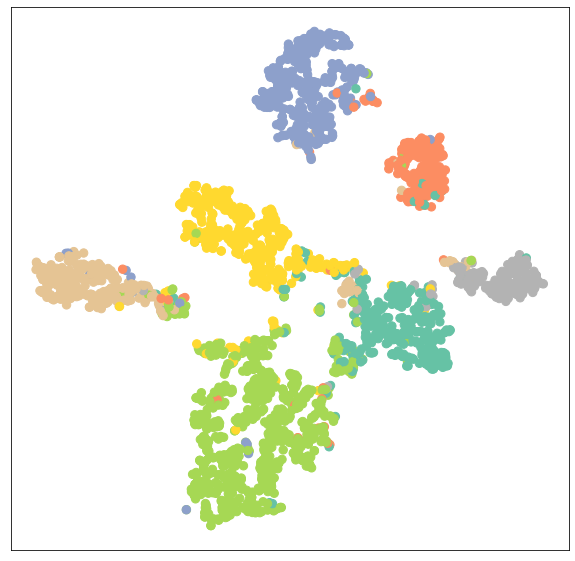

In [ ]:
GCN_Model.eval()

GCN_Model_test_out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(GCN_Model_test_out, color = dataset_PGExplainer.y)

# **PGExplainer**


In [ ]:
import os
import os.path as osp

import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import download_url, extract_zip

from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
from dig.xgraph.utils.compatibility import compatible_state_dict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from dig.xgraph.method import PGExplainer

explainer = PGExplainer(GCN_Model, in_channels=300, device=device, explain_graph=False, num_hops=1, epochs=1)

explainer.train_explanation_network(dataset2)
torch.save(explainer.state_dict(), 'tmp.pt')
state_dict = torch.load('tmp.pt')
explainer.load_state_dict(state_dict)


100%|██████████| 1891/1891 [00:00<00:00, 121660.74it/s]
1891it [08:20,  3.78it/s]

Epoch: 0 | Loss: 0.37248503113838255
training time is 500.26s


<All keys matched successfully>

In [ ]:

model = explainer.state_dict()

In [ ]:
print(len(model))
print(model)

12
OrderedDict([('model.conv1.bias', tensor([ 1.1998e-01,  8.7195e-02,  1.0731e-01,  1.3494e-01,  8.5059e-02,
         1.0733e-01,  5.7196e-02, -2.0533e-02,  1.2147e-01, -1.4802e-03,
         8.7266e-02, -5.5693e-03,  9.5937e-02, -7.6432e-03,  1.7406e-01,
         6.2067e-02, -3.0831e-04, -1.7916e-03,  8.0041e-02, -3.2469e-03,
         8.1889e-02, -5.6002e-03,  9.6129e-02,  1.1479e-01,  1.1792e-01,
         9.0772e-02,  5.7635e-02, -1.1159e-03,  2.2524e-01,  5.6572e-02,
         8.6635e-02,  7.7208e-02, -6.1670e-06,  9.0478e-02,  5.5279e-02,
         4.1924e-02,  5.7014e-02,  8.0339e-02,  7.8754e-02, -5.8508e-03,
         2.7885e-01,  1.1171e-01,  6.6823e-02,  5.4066e-02,  4.6925e-02,
        -3.3898e-04,  1.1579e-01, -2.6344e-03, -1.6361e-05, -1.9634e-05,
         5.8349e-02,  8.0241e-02,  9.9066e-02, -8.4052e-05,  2.5030e-01,
        -1.1393e-02, -6.7120e-05, -4.2509e-03,  3.9437e-02, -3.3826e-04,
         1.3025e-01,  9.7449e-06,  1.2531e-01,  2.8919e-01,  6.3326e-02,
         2.403

In [ ]:
node_indices = torch.where(dataset[0].train_mask * dataset[0].y != 0)[0].tolist()

In [ ]:
print(len(dataset2.data))
print(len(dataset_PGExplainer.x))
print(dataset_PGExplainer.keys)
print('whole dataset: ', len(dataset_PGExplainer.train_mask))
print('training dataset: ', len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print('test dataset: ', len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))


6
2708
['y', 'edge_index', 'val_mask', 'x', 'train_mask', 'test_mask']
whole dataset:  2708
training dataset:  1891
test dataset:  817


In [ ]:
Masks = []
for i in range(len(dataset_PGExplainer.train_mask)):
  with torch.no_grad():
    walks, masks, related_preds = explainer(dataset_PGExplainer.x, dataset_PGExplainer.edge_index, node_idx=i, y=dataset_PGExplainer.y)
    print(i)
    print(masks)

    for mask in masks:
      Masks.append(mask.detach().numpy().tolist())
    #print(Masks[0])
    #print(related_preds[0])
    #print()
#print((data.edge_index[0] == 0).nonzero())
print(len((dataset[0].edge_index[0] == 1000).nonzero()))


Streaming output truncated to the last 5000 lines.
894
[tensor([0.6992, 0.6992, 0.6936, 0.7003, 0.6936, 0.7003])]
895
[tensor([0.6781, 0.6708, 0.6708, 0.6772, 0.6699, 0.6699, 0.6781, 0.6772, 0.6762,
        0.6819, 0.6819, 0.6762, 0.6708, 0.6699, 0.6819, 0.6746, 0.6708, 0.6699,
        0.6819, 0.6746])]
896
[tensor([0.6525, 0.6525])]
897
[tensor([0.7233, 0.6880, 0.7233, 0.7204, 0.7221, 0.7222, 0.7215, 0.7233, 0.7213,
        0.7221, 0.7204, 0.7221, 0.7222, 0.7215, 0.6880, 0.7233, 0.7213, 0.7221])]
898
[tensor([0.6443, 0.6351, 0.6443, 0.6452, 0.6443, 0.6452, 0.6452, 0.6362, 0.6351,
        0.6443, 0.6452, 0.6362])]
899
[tensor([0.7421, 0.7421, 0.7403, 0.7395, 0.7474, 0.7403, 0.7395, 0.7474])]
900
[tensor([0.7412, 0.7477, 0.7412, 0.7477])]
901
[tensor([0.7050, 0.6904, 0.6904, 0.7050, 0.7032, 0.7050, 0.7032, 0.7051, 0.7050,
        0.7032, 0.6866, 0.6904, 0.7050, 0.6906, 0.7032, 0.6866, 0.7051, 0.6906,
        0.6906, 0.6904, 0.7050, 0.6906])]
902
[tensor([0.7180, 0.7180, 0.7180, 0.7180, 

In [ ]:
print(len(Masks))
print(Masks[0])
sum=0
for i in range(len(Masks)):
  sum = sum + len(Masks[i])
print(sum)
print(len(dataset_PGExplainer.edge_index[0]))
print(dataset_PGExplainer.num_edge_features)

2708
[0.715925931930542, 0.7202897667884827, 0.7202897667884827, 0.715925931930542, 0.7202897667884827, 0.7102001905441284, 0.7202897667884827, 0.7102001905441284]
30892
10556
0


In [ ]:
print(len(Masks))

2708


# **Index List of each Category**

In [ ]:
train_index_list = []
for i in range(len(dataset_PGExplainer.train_mask)):
  if dataset_PGExplainer.train_mask[i]:
    train_index_list.append(i)

test_index_list = []
for i in range(len(dataset_PGExplainer.test_mask)):
  if dataset_PGExplainer.test_mask[i]:
    test_index_list.append(i)

val_index_list = []
for i in range(len(dataset_PGExplainer.val_mask)):
  if dataset_PGExplainer.val_mask[i]:
    val_index_list.append(i)

In [ ]:
print(train_index_list)
print(len(train_index_list))

print(test_index_list)
print(len(test_index_list))

print(val_index_list)
print(len(val_index_list))

#print(len(dataset_PGExplainer.x[0]))

[1, 2, 3, 4, 5, 6, 7, 9, 11, 13, 14, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 45, 46, 47, 49, 50, 52, 54, 58, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 83, 84, 85, 88, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 105, 106, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 121, 123, 125, 126, 128, 132, 134, 135, 136, 137, 139, 141, 142, 145, 147, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 178, 180, 183, 184, 185, 186, 188, 190, 192, 193, 194, 195, 197, 198, 200, 201, 203, 205, 206, 208, 209, 210, 212, 213, 214, 215, 216, 217, 220, 221, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 243, 245, 249, 250, 251, 252, 253, 254, 255, 256, 257, 260, 262, 263, 264, 265, 266, 267, 269, 270, 271, 272, 274, 275, 277, 279, 280, 283, 284, 285, 286, 287, 291, 293, 294, 295, 296, 297, 298, 299, 300,

# **Features of Each Category**

In [ ]:
training_nodes = dataset_PGExplainer.x[train_index_list]
test_nodes = dataset_PGExplainer.x[test_index_list]
val_nodes = dataset_PGExplainer.x[val_index_list]

print(len(training_nodes))
print(len(test_nodes))
print(len(val_nodes))
print(training_nodes)

training_nodes = training_nodes.detach().cpu().numpy()
training_nodes = training_nodes.tolist()

test_nodes = test_nodes.detach().cpu().numpy()
test_nodes = test_nodes.tolist()

val_nodes = val_nodes.detach().cpu().numpy()
val_nodes = val_nodes.tolist()

print(len(training_nodes))
print(len(test_nodes))
print(len(val_nodes))
#for i in range(num_classes):
#    index = (dataset.data.y == i).nonzero().view(-1)

1891
817
500
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
1891
817
500


# **Eadges of each Node**
Training

In [ ]:
edges_training_dataset = []
first_node_edge_training_dataset = []
second_node_edge_training_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in train_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_training_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_training_dataset.extend(B)

10556


In [ ]:
edges_training_dataset.append(first_node_edge_training_dataset)
edges_training_dataset.append(second_node_edge_training_dataset)

# **Eadges of each Node**
Test

In [ ]:
edges_test_dataset = []
first_node_edge_test_dataset = []
second_node_edge_test_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in test_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_test_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_test_dataset.extend(B)

10556


In [ ]:
edges_test_dataset.append(first_node_edge_test_dataset)
edges_test_dataset.append(second_node_edge_test_dataset)

# **Eadges of each Node**
Val

In [ ]:
edges_val_dataset = []
first_node_edge_val_dataset = []
second_node_edge_val_dataset = []
print(len(dataset_PGExplainer.edge_index[0]))

for node in val_index_list:
  index = (dataset_PGExplainer.edge_index[0] == node).nonzero().view(-1)
  A = dataset_PGExplainer.edge_index[0][index]
  A = A.detach().cpu().numpy()
  A = A.tolist()
  first_node_edge_val_dataset.extend(A)
  
  B = dataset_PGExplainer.edge_index[1][index]
  B = B.detach().cpu().numpy()
  B = B.tolist()
  second_node_edge_val_dataset.extend(B)

10556


In [ ]:
edges_val_dataset.append(first_node_edge_val_dataset)
edges_val_dataset.append(second_node_edge_val_dataset)

In [ ]:
print(dataset_PGExplainer.train_mask)
print(dataset_PGExplainer.test_mask)
print(dataset_PGExplainer.val_mask)
print()
print(edges_training_dataset[0])
print(edges_training_dataset[1])
print()
print(len(edges_training_dataset[0]), len(edges_training_dataset[1]))
print(len(edges_test_dataset[0]), len(edges_test_dataset[1]))
print(len(edges_val_dataset[0]), len(edges_val_dataset[1]))
#print(dataset_PGExplainer.edge_index)
#for i in range(len(dataset_PGExplainer.edge_index[0])):
#  print(dataset_PGExplainer.edge_index[0][i], dataset_PGExplainer.edge_index[1][i])
#  if i == 1000:
#    break

tensor([False,  True,  True,  ..., False,  True, False])
tensor([ True, False, False,  ...,  True, False,  True])
tensor([False, False, False,  ..., False, False, False])

[1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 9, 9, 11, 11, 13, 13, 14, 14, 14, 14, 14, 16, 16, 16, 16, 17, 17, 17, 17, 17, 19, 20, 20, 20, 20, 20, 22, 22, 22, 22, 22, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 29, 29, 30, 30, 30, 30, 30, 30, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 41, 41, 41, 41, 43, 43, 43, 43, 43, 43, 45, 45, 45, 45, 45, 45, 46, 46, 47, 47, 49, 49, 50, 52, 52, 52, 52, 52, 54, 54, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 61, 61, 61, 61, 61, 62, 63, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 67, 67, 67, 69, 69, 69, 69, 69, 69, 69, 70, 70, 71, 71, 71, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74,

# **Labels of each Category**

In [ ]:
training_labels = dataset_PGExplainer.y[train_index_list]
test_labels = dataset_PGExplainer.y[test_index_list]
val_labels = dataset_PGExplainer.y[val_index_list]

print(len(training_labels))
print(len(test_labels))
print(len(val_labels))
print(training_labels)

training_labels = training_labels.detach().cpu().numpy()
training_labels = training_labels.tolist()

test_labels = test_labels.detach().cpu().numpy()
test_labels = test_labels.tolist()

val_labels = val_labels.detach().cpu().numpy()
val_labels = val_labels.tolist()

print(len(training_labels))
print(len(test_labels))
print(len(val_labels))

1891
817
500
tensor([4, 4, 0,  ..., 3, 3, 3])
1891
817
500


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


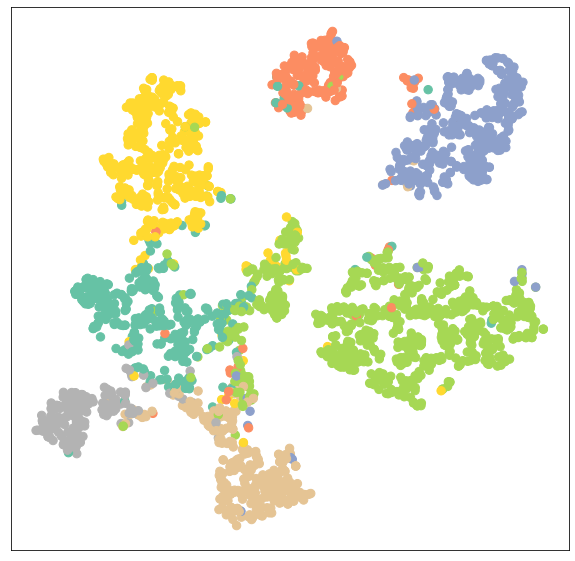

In [ ]:
out = GCN_Model(dataset_PGExplainer.x, dataset_PGExplainer.edge_index)
visualize(out, color=data.y)

In [ ]:
print(dataset_PGExplainer.keys)
print(len(dataset_PGExplainer.y[dataset_PGExplainer.train_mask]))
print(len(dataset_PGExplainer.y[dataset_PGExplainer.test_mask]))
print(len(dataset_PGExplainer.y[dataset_PGExplainer.val_mask]))
#dataset_PGExplainer.y[dataset_PGExplainer.train_mask]
print()
print(len(dataset_PGExplainer.x[dataset_PGExplainer.train_mask]))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.test_mask]))
print(len(dataset_PGExplainer.x[dataset_PGExplainer.val_mask]))

print(len(dataset_PGExplainer.train_mask))
print(len(dataset_PGExplainer.test_mask))
print()
print(dataset_PGExplainer.train_mask)
print(dataset_PGExplainer.test_mask)
print(dataset_PGExplainer.val_mask)
print()
print(dataset_PGExplainer.edge_index)
print('===================================')
print(dataset_PGExplainer.x[dataset_PGExplainer.train_mask])



sum1=0
for i in dataset_PGExplainer.train_mask:
  if i:
    sum1 = sum1 + 1
print(sum1)

sum2=0
for i in dataset_PGExplainer.test_mask:
  if i:
    sum2 = sum2 + 1
print(sum2)

sum3=0
for i in dataset_PGExplainer.val_mask:
  if i:
    sum3 = sum3 + 1
print(sum3)



'''sum1=0
for i in data.train_mask:
  if i:
    sum1 = sum1 + 1
print(sum1)

sum2=0
for i in data.test_mask:
  if i:
    sum2 = sum2 + 1
print(sum2)

sum3=0
for i in data.val_mask:
  if i:
    sum3 = sum3 + 1
print(sum3)'''

['y', 'edge_index', 'val_mask', 'x', 'train_mask', 'test_mask']
1891
817
500

1891
817
500
2708
2708

tensor([False,  True,  True,  ..., False,  True, False])
tensor([ True, False, False,  ...,  True, False,  True])
tensor([False, False, False,  ..., False, False, False])

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
1891
817
500


'sum1=0\nfor i in data.train_mask:\n  if i:\n    sum1 = sum1 + 1\nprint(sum1)\n\nsum2=0\nfor i in data.test_mask:\n  if i:\n    sum2 = sum2 + 1\nprint(sum2)\n\nsum3=0\nfor i in data.val_mask:\n  if i:\n    sum3 = sum3 + 1\nprint(sum3)'